In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime

# IMAGE IMPORTS
from PIL import Image

# GIS IMPORTS
from affine import Affine
import pandas as pd

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

IO directories depending on which machine. 

In [2]:
username = os.getlogin()

dnn_params = {}
dnn_params['CLNN'] = {}
dnn_params['TPNN'] = {}
dnn_params['RLNN'] = {}
dnn_params['FLNN'] = {}
dnn_params['TLNN'] = {}


if username == 'fhacesga':
    base_input_path   = r"D:\FloodChange\AAA_HistoricalDownload\ZIP\\"
    base_output_path  = r"C:\Users\\"+username+"\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
elif username == 'fhace':
    ref_dir = r"C:\Users\fhace\Desktop\FIRMs\data\AAA_ReferenceDatasets\\"
    base_output_path = r"C:\Users\fhace\Desktop\FIRMs\data\Outputs\\"
    dnn_params['TLNN']['model_weights']    = r"C:\Users\fhace\Desktop\FIRMs\data\BBNN\curr_weights.pt"
    dnn_params['CLNN']['model_checkpoint'] = r"C:\Users\fhace\Desktop\FIRMs\data\RLNN\checkpoint_101423.pth"
    dnn_params['TPNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\TPNN\checkpoint_091523_pyramids_2.pth"
    dnn_params['RLNN']['model_checkpoint'] = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\RLNN\checkpoint_091323.pth"
    
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

if not initialize:
    initialize = init_databases(ref_dir)

Create working dir and unzip all files if needed

In [3]:
proc_dir = None
# proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\"

if proc_dir is None:
    datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    proc_dir     = os.path.join(base_output_path, datetime_str)
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    print(proc_dir)
    os.makedirs(proc_dir)
    os.makedirs(unzipped_dir)
    os.makedirs(outputs_dir)
    extractZipFiles(base_input_path, unzipped_dir)
else:
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    rmtree(outputs_dir)
    os.makedirs(outputs_dir)

Read through all the images in the directory. Some images are saved as Multi-page TIFF files. These need to be exported into individual images. We'll do that first

In [4]:
for filename in tqdm(glob.glob(unzipped_dir + "\\*.tif*")):
    tiff_file = os.path.join(unzipped_dir, filename)
    try:
    # Check if the file is a multi-page TIFF
        with Image.open(tiff_file) as img:
            if img.is_animated:    
                for i in range(img.n_frames):
                    try:
                        img.seek(i)
                        output_filename = f"{os.path.splitext(tiff_file)[0]}_{i+1}{os.path.splitext(tiff_file)[1]}"
                        img.save(output_filename, format=img.format)
                    except:
                        print(f"Error with {tiff_file} page {i}")
                        continue
    except:
        print(f"Error opening {tiff_file}")
        continue

    os.remove(tiff_file)

  0%|          | 0/7 [00:00<?, ?it/s]

Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485479B.tif
Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485479C.tif
Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485481A.tif
Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485510.tif
Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485510B.tif
Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485514B.tif
Error opening C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\485516A.tif


Here we're using heuristics to identify indices within all the image files. These include:
- Files that are shorter than 12 characters
- Files that have the ```IND``` marker

We create a Pandas DataFrame with the files matching. We then add several fields as below

In [5]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{unzipped_dir}/*")

# FILTER IMAGES USING HEURISTICS
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(unzipped_dir + "\\*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# CREATE DATAFRAME
index_files = pd.DataFrame(index_files, columns=["FilePath"])

# INDEX ATTRIBUTES TO BE ADDED
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]    # BASENAME
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)   # 
index_files["GEOID"]    = index_files["Location"].apply(getGEOID)       # GET GEOID FOR EACH INDEX
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)       # GET GEOMETRY FROM MATCHING GEOIDs

C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480035IND0_0490.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480035IND0_0490.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480035IND0_0490.jpg: 1920x1920 1 tile, 51 countys, 3 legends, 3012.5ms
Speed: 35.9ms preprocess, 3012.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1920, 1920)


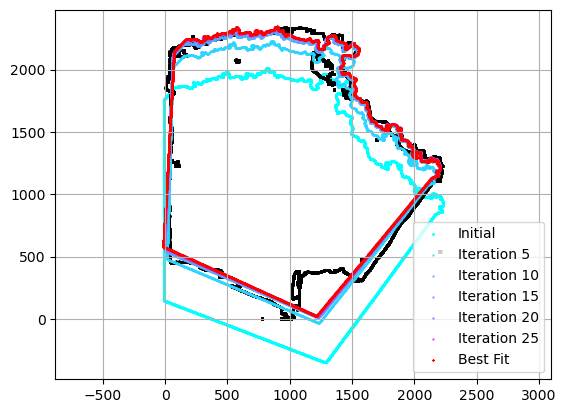

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480035IND0_0789.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480035IND0_0789.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480035IND0_0789.jpg: 1920x1920 1 tile, 51 countys, 3 legends, 3325.6ms
Speed: 37.9ms preprocess, 3325.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1920, 1920)


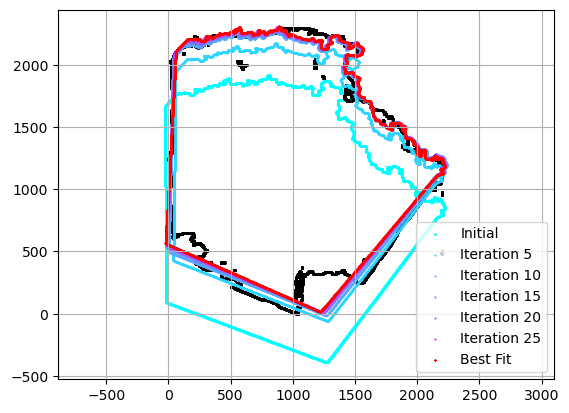

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480035IND0_0990.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480035IND0_0990.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480035IND0_0990.jpg: 1920x1920 1 tile, 48 countys, 3 legends, 3133.1ms
Speed: 45.9ms preprocess, 3133.1ms inference, 2.0ms postprocess per image at shape (1, 3, 1920, 1920)


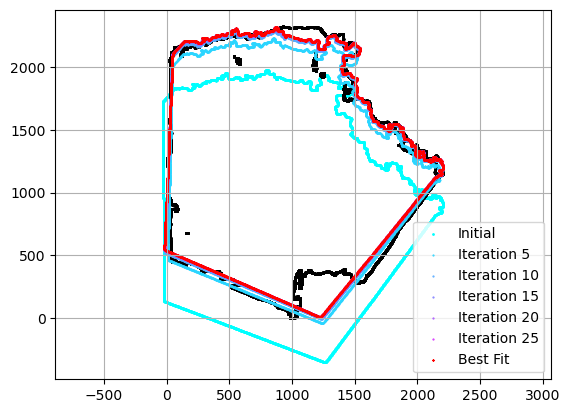

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480035IND0_1084.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480035IND0_1084.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480035IND0_1084.jpg: 1920x1920 1 tile, 50 countys, 2 legends, 3425.4ms
Speed: 41.9ms preprocess, 3425.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1920, 1920)


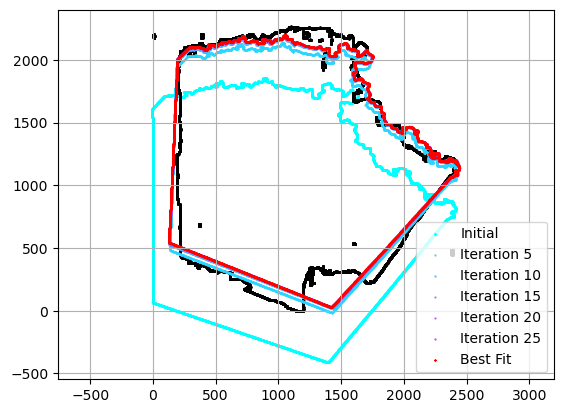

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480035IND0_1091.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480035IND0_1091.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480035IND0_1091.jpg: 1920x1920 1 tile, 49 countys, 2 legends, 3376.4ms
Speed: 35.9ms preprocess, 3376.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1920, 1920)


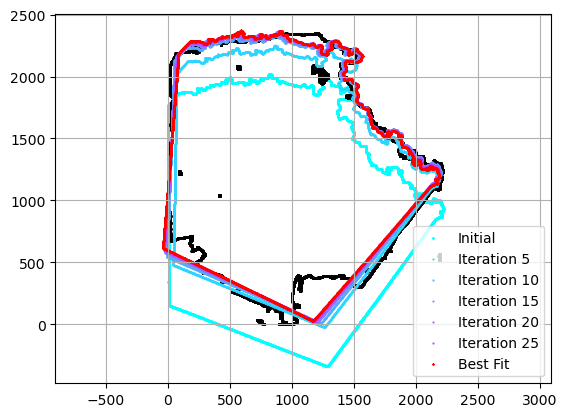

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480038IND0_1185.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480038IND0_1185.tif


  0%|          | 0/1 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480038IND0_1185.jpg: 1472x1920 2 tiles, 1 county, 1 legend, 2432.0ms
Speed: 24.9ms preprocess, 2432.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1472, 1920)


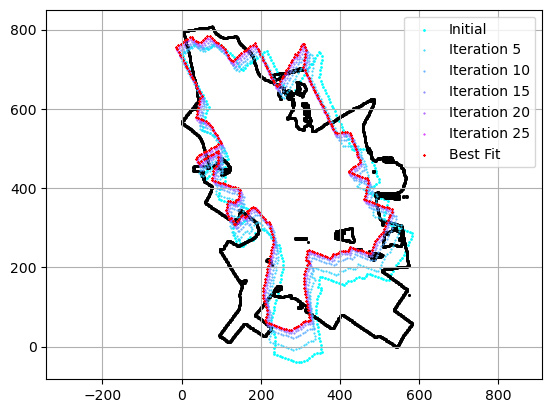

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480045IND0_0186.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480045IND0_0186.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480045IND0_0186.jpg: 1696x1920 1 tile, 61 countys, 1 legend, 2646.9ms
Speed: 35.9ms preprocess, 2646.9ms inference, 2.0ms postprocess per image at shape (1, 3, 1696, 1920)


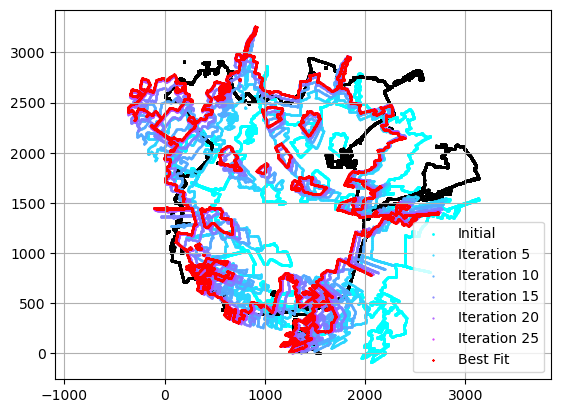

ERROR : 'bbox' transform_info
ERROR : only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices output_transform
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Inputs\480045IND0_0189.jpg
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\\Outputs\480045IND0_0189.tif


  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-12_23-27-54\Inputs\480045IND0_0189.jpg: 1664x1920 1 tile, 61 countys, 2 legends, 2702.1ms
Speed: 34.0ms preprocess, 2702.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1664, 1920)


In [6]:
def getBBOX_coords(tile_ds : rio.DatasetReader, bbox : list) -> list:
    """
    Converts Bounding Box pixel coordinates into actual coordinates by using the input rasterio dataset

    Parameters:
        tile_ds (rasterio.Dataset): Post-ICP rasterio dataset saved with a world file.
        bbox (iterable): Bounding box coordinates in format (x_min, y_min, x_max, y_max),
                      normalized by the total image width and height.

    Returns:
        coords (list): list of raster coordinates in (x_min, y_min, x_max, y_max) format.
    """
    # x1, y1 = rio.transform.xy(tile_ds.transform, bbox[0], bbox[1]) WRONG X, Y 
    # x2, y2 = rio.transform.xy(tile_ds.transform, bbox[2], bbox[3]) WRONG X, Y
    x1, y1 = rio.transform.xy(tile_ds.transform, bbox[1], bbox[0]) 
    x2, y2 = rio.transform.xy(tile_ds.transform, bbox[3], bbox[2])
    return [x1, y1, x2, y2]

def bbox_to_coords(bbox):
    '''
    x1, y1, x2, y2 = bbox

    x_min = np.min([x1, x2])    
    x_max = np.max([x1, x2])    
    y_min = np.min([y1, y2])    
    y_max = np.max([y1, y2])    

    
    '''
    x_min, y_min, x_max, y_max = bbox

    xs = [x_min, x_max, x_min, x_max]
    ys = [y_min, y_min, y_max, y_max]
    return xs, ys# [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]

# def getTileTransform(tile):

def getTileAffine(tile, baseaffine=None):

    b = baseaffine

    w, h = tile['data'].size

    x_i = [0, w, 0, w]
    y_i = [0, 0, h, h]
    x_c, y_c = bbox_to_coords(tile['coords'])

    test = pd.DataFrame()
    test["x_i"] = x_i
    test["y_i"] = y_i
    test["x_c"] = x_c
    test["y_c"] = y_c

    a = affineTransformation(x_i, y_i, x_c, y_c)

    matrix = None
    if b is not None: 
        matrix = b.flatten()[:6]
        matrix[2] = a.matrix.flatten()[2]
        matrix[5] = a.matrix.flatten()[5]
    else:
        matrix = a.matrix.flatten()[:6]
         

    return rio.Affine(*matrix)

def saveTile(fn, tile, baseaffine=None):
    transform = tile['affine'] if 'affine' in tile else getTileAffine(tile, baseaffine=baseaffine)
    image = np.asarray(tile['data'])
    epsg_code = 3857
    with rio.open(fn, 'w',
        driver='GTiff',
        height=image.shape[0],
        width=image.shape[1],
        count=1,
        dtype=image.dtype,
        crs=f'EPSG:{epsg_code}',
        transform=transform) as dst:
            dst.write(image, 1)    

def ICPtoCRSTransform(image_arry, transform_dict):
    # REVERSE Y AXIS
    rev_y_axis = np.array([[1, 0, 0],
                        [0,-1, 0],
                        [0, 0, 1]])

    # move = original_homography @ np.array([0, image_t.shape[0], 0])
    translation = np.eye(3)
    translation[1, 2] = image_arry.shape[0]

    transform_dict['translation'] = translation
    
    # adjustment =  np.linalg.inv(transform_dict['best'].copy())
    # rev_adj = adjustment.copy()
    # rev_adj[1, 1] = rev_adj[1, 1] * -1
    transform_dict['rev_adj'] = np.linalg.inv(transform_dict['best'].copy())

    transform_dict['flip'] = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
    ])
    
    # output_transform = transform_dict['initial'] @ transform_dict['translation'] @ transform_dict['rev_adj']
    output_transform = transform_dict['initial'] @ transform_dict['rev_adj'] @ transform_dict['translation']  @ transform_dict['flip']
    offsets = output_transform @ np.array([[0, 0, 1], [image_arry.shape[0], 0, 1]]).T
    offsets = offsets[:, 1] - offsets[:, 0]
    transform_dict['offsets'] = offsets

    return output_transform, transform_dict


verbose = True

TPNN = None
RLNN = None
CLNN = None
TLNN = None

gen_dict = {}

for i, row in index_files.iterrows():
    
    print(row["FilePath"])
    
    try:

        filename = os.path.basename(row["FilePath"])
        
        # READ FILES AND CONVERT TO GRAYSCALE
        image = cv2.imread(row["FilePath"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_arry = np.asarray(image)
        
        # SAVE IMAGE TO OUTPUT DIRECTORY
        output_image_fn = os.path.join(outputs_dir, filename.split(".")[0] + ".tif")
        print(output_image_fn)
        copyfile(row["FilePath"], output_image_fn)

        # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
        output = getBoundaryPoints(row, distance=100)
        if output is None:
            print(f"COULD NOT FIND SHAPEFILE FOR {filename}")
            continue
        point_boundary_gdf, shp_bounds = output
        
        # RUN IMAGES THROUGH DNNs
        classifications, TPNN  = findKeypoints(image, model=TPNN, **dnn_params['TPNN'])
        effectiveArea, RLNN    = findSquares(image, model=RLNN, **dnn_params['RLNN'])
        countyArea, CLNN       = findCounty(image, model=CLNN, **dnn_params['CLNN'])
        tiles, TLNN            = findTiles(row["FilePath"], model=TLNN, **dnn_params['TLNN'], 
                                           save_dir=os.path.join(outputs_dir, filename.split(".")[0] + "_BBNN.tif"))

        dnn_outputs = {
            "classifications"   : classifications,
            "effectiveArea"     : effectiveArea,
            "countyArea"    : countyArea,
            "tiles"         : tiles
        }
        
        # GET COUNTY BOUNDS IDENTIFIED IN INDEX BY TLNN
        # bounds_panels = tiles["county"]["bbox"]
        bounds_panels = find_bbox(dnn_outputs['countyArea'][:, :, 1])

        # SKIP IF WE CAN'T FIND BOUNDARY IN EXISTING DATABASES
        if point_boundary_gdf is None:
            continue

        # DEFINE BOUNDARY STRUCTU
        boundaries = {
            "point_boundary_gdf"    : point_boundary_gdf,
            "shp_bounds"            : shp_bounds,
            "bounds_panels"         : bounds_panels,
        }

        # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
        key = findKey(row["Basename"])    
        if key is None:
            print(f"Could not find key in {filename}")
        
        # DO ICP
        transform_dict = performICPonIndex(boundaries, dnn_outputs, debug=False, plot=True, rotation=True, shear=False, perspective=False, icp_iterations=30)

        # GET TRANSFORM FROM ICP TO CRS TRANSFORM
        output_transform, transform_dict = ICPtoCRSTransform(image_arry, transform_dict)

        # GET OUTPUT TRANSFORM INTO AFFINE AND WRITE
        output_affine = Affine(*output_transform.flatten()[:6])
        # write_world_file_from_affine(output_affine, get_world_file_path(output_image_fn))
        with rio.open(output_image_fn, 'w',
            driver='GTiff',
            height=image.shape[0], width=image.shape[1],
            count=1, dtype=image.dtype,
            crs=f'EPSG:3857',
            transform=rio.Affine(*output_transform.flatten()[:6])) as dst:
                dst.write(image, 1)   

        tiles['transform_info'] = transform_dict
        tiles['output_transform'] = output_transform
        gen_dict[filename] = tiles

        
        src = rio.open(output_image_fn)
        for iii, (k, v) in enumerate(tiles.items()):
            try:
                tiles[k]['coords'] = getBBOX_coords(src, tiles[k]['bbox'])
                saveTile(os.path.join(outputs_dir, f"{filename}_{k}.tif"), v, baseaffine=output_transform)
            except Exception as e:
                print("ERROR : "+str(e) + f" {k}")
                continue
    except Exception as e:
        print("ERROR : "+str(e))
        continue

with open(os.path.join(outputs_dir, "IndexCoords.pkl"), 'wb') as handle:
    pickle.dump(gen_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
    

[ 350  528 2594 2890]


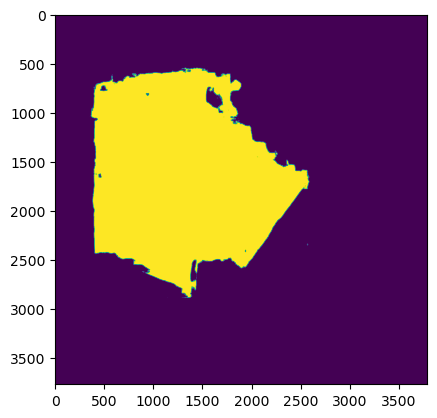

In [ ]:
plt.imshow(dnn_outputs['countyArea'][:, :, 1])